In [368]:
## Import and data processing

import json
import pandas as pd
import numpy as np


with open('sreality/output.json') as data_file: data = json.load(data_file)
    
df = pd.io.json.json_normalize(data)

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 30)

df.shape

(980, 14)

In [369]:
df.head(3)

,id,location,navic,novostavba,plocha,podlazi,price,stavOb,stavba,stitky,trida,url,velikost,vlastnictvi
0,2558665052,"Kloboukova, Praha 4 - Chodov",",vytah",False,83,3. podlaží z celkem 6 včetně 1 podzemního,4 290 000 Kč,veryGood,panelova,"Lodžie,Panelová,Částečně vybavený",C,3+1/praha-chodov-kloboukova/2558665052,3+1,osobni
1,2667434332,"Družstevní, Praha 4 - Nusle",,False,43,3. podlaží z celkem 5 včetně 1 podzemního,3 990 000 Kč,afterRec,cihlova,"Po rekonstrukci,Lodžie,Vybavený",C,2+kk/praha-nusle-druzstevni/2667434332,2+kk,osobni
2,3520147804,"Menclova, Praha 8 - Libeň","balkon,vytah",False,NaN,NaN,6 321 430 Kč,NaN,ostatni,Ve výstavbě,No,2+kk/praha-liben-menclova/3520147804,2+kk,osobni


In [370]:
df.index = df['id'].apply(pd.to_numeric)
del df['id']


In [371]:
# Column names:
df.columns

Index([u'location', u'navic', u'novostavba', u'plocha', u'podlazi', u'price',
       u'stavOb', u'stavba', u'stitky', u'trida', u'url', u'velikost',
       u'vlastnictvi'],
      dtype='object')

In [372]:
df['location'].value_counts()[:5]

Štolcova, Praha 4 - Modřany           18
Kolbenova, Praha 9 - Vysočany         17
Rohanské nábřeží, Praha 8 - Karlín    13
Voctářova, Praha - Praha 8            12
Libeňský ostrov, Praha 8 - Libeň       9
Name: location, dtype: int64

In [373]:
df['vlastnictvi'].value_counts()

osobni           893
druzstevni        85
statni-obecni      2
Name: vlastnictvi, dtype: int64

In [374]:
df[df['price'] == u'Info o ceně u RK'][:3]

,location,navic,novostavba,plocha,podlazi,price,stavOb,stavba,stitky,trida,url,velikost,vlastnictvi
id,,,,,,,,,,,,,
3466731868,"Na Výrovně, Praha 5 - Stodůlky",",garaz,vytah",False,45,4. podlaží z celkem 5,Info o ceně u RK,veryGood,ostatni,"Balkon,Garáž,Vybavený",G,2+kk/praha-stodulky-na-vyrovne/3466731868,2+kk,osobni
3161796956,"Ke Kamýku, Praha - Kamýk",lodzie,True,106,2. podlaží z celkem 3,Info o ceně u RK,Novostavba,cihlova,,B,3+kk/praha-kamyk-ke-kamyku/3161796956,3+kk,osobni
80159068,"Jílovská, Praha - Praha 4",lodzie,False,64,10. podlaží z celkem 11,Info o ceně u RK,afterRec,panelova,"Po rekonstrukci,Panelová",No,3+1/praha-praha-4-jilovska/80159068,3+1,osobni


In [375]:
# Removing our 'priceless' offers
df = df[df['price'] != u'Info o ceně u RK']

In [376]:
df['price'] = df['price'].map(lambda x: x[:x.find(u' Kč')].replace(' ',''))

In [377]:
# converting price to int64
df['price'] = pd.to_numeric(df['price'], errors='coerce')

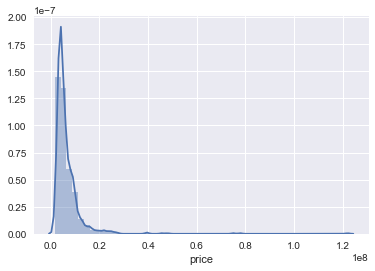

In [378]:
%matplotlib inline
import seaborn as sns
# price destribution
sns.distplot(df['price']);

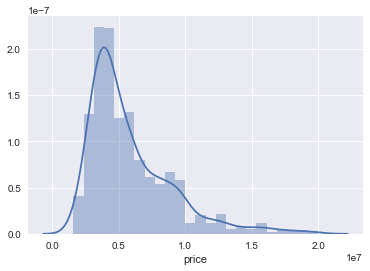

In [379]:
df = df[df['price'] < 20000000]
df = df[df['price'] > 1500000]
sns.distplot(df['price']);

In [380]:
# overall info
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 916 entries, 2558665052 to 3837731164
Data columns (total 13 columns):
location       916 non-null object
navic          916 non-null object
novostavba     916 non-null object
plocha         757 non-null object
podlazi        757 non-null object
price          916 non-null int64
stavOb         874 non-null object
stavba         916 non-null object
stitky         916 non-null object
trida          916 non-null object
url            916 non-null object
velikost       916 non-null object
vlastnictvi    916 non-null object
dtypes: int64(1), object(12)
memory usage: 100.2+ KB


## Filling missing fields

### Užitná plocha

In [381]:
df['plocha'] = pd.to_numeric(df['plocha'], errors='coerce')

In [382]:
df[u'stavOb'].value_counts()

Novostavba    298
veryGood      284
good          135
afterRec      124
beforeRec      33
Name: stavOb, dtype: int64

### Lodžie, Novostavba, sklep, parkovani

In [383]:
def contains_converter(mapping, param):
    for i in mapping:        
        if param.find(i) > -1:
            return mapping[i]
    return ''
balcony_mapping = {
        u'balkon':u'balkon',
        u'lodzie':u'lodzie',
        u'terasa':u'terasa'    
    }

df['sklep'] = df['navic'].str.contains('sklep')
df['parkovani'] = df['navic'].str.contains('parkovani')
df['vytah'] = df['navic'].str.contains('vytah')
df['balkon'] = df['navic'].map(lambda x: contains_converter(balcony_mapping, x))
df.head(3)

,location,navic,novostavba,plocha,podlazi,price,stavOb,stavba,stitky,trida,url,velikost,vlastnictvi,sklep,parkovani,vytah,balkon
id,,,,,,,,,,,,,,,,,
2558665052,"Kloboukova, Praha 4 - Chodov",",vytah",False,83.0,3. podlaží z celkem 6 včetně 1 podzemního,4290000,veryGood,panelova,"Lodžie,Panelová,Částečně vybavený",C,3+1/praha-chodov-kloboukova/2558665052,3+1,osobni,False,False,True,
2667434332,"Družstevní, Praha 4 - Nusle",,False,43.0,3. podlaží z celkem 5 včetně 1 podzemního,3990000,afterRec,cihlova,"Po rekonstrukci,Lodžie,Vybavený",C,2+kk/praha-nusle-druzstevni/2667434332,2+kk,osobni,False,False,False,
3520147804,"Menclova, Praha 8 - Libeň","balkon,vytah",False,NaN,NaN,6321430,NaN,ostatni,Ve výstavbě,No,2+kk/praha-liben-menclova/3520147804,2+kk,osobni,False,False,True,balkon


### metro and public transport

In [384]:
df = df.dropna(axis=0, how='any')
df.isnull().any()

location       False
navic          False
novostavba     False
plocha         False
podlazi        False
price          False
stavOb         False
stavba         False
stitky         False
trida          False
url            False
velikost       False
vlastnictvi    False
sklep          False
parkovani      False
vytah          False
balkon         False
dtype: bool

In [385]:
df['floor'] = df['podlazi'].map(lambda x: x[:x.find(u'. podlaží z celkem ')].replace(' ',''))
df['firstFloor'] = df['floor'].map(lambda x: True if x == '1' else False)
df.head()

,location,navic,novostavba,plocha,podlazi,price,stavOb,stavba,stitky,trida,url,velikost,vlastnictvi,sklep,parkovani,vytah,balkon,floor,firstFloor
id,,,,,,,,,,,,,,,,,,,
2558665052,"Kloboukova, Praha 4 - Chodov",",vytah",False,83.0,3. podlaží z celkem 6 včetně 1 podzemního,4290000,veryGood,panelova,"Lodžie,Panelová,Částečně vybavený",C,3+1/praha-chodov-kloboukova/2558665052,3+1,osobni,False,False,True,,3,False
2667434332,"Družstevní, Praha 4 - Nusle",,False,43.0,3. podlaží z celkem 5 včetně 1 podzemního,3990000,afterRec,cihlova,"Po rekonstrukci,Lodžie,Vybavený",C,2+kk/praha-nusle-druzstevni/2667434332,2+kk,osobni,False,False,False,,3,False
3986825564,"Kukelská, Praha 9 - Hloubětín",",vytah",False,63.0,1. podlaží z celkem 9 včetně 1 podzemního,3645000,good,panelova,"Lodžie,Panelová,Nevybavený",G,2+kk/praha-hloubetin-kukelska/3986825564,2+kk,osobni,False,False,True,,1,True
2722771292,"Počernická, Praha 10 - Malešice",",garaz,vytah",True,141.0,16. podlaží z celkem 16,10959000,Novostavba,cihlova,,C,4+kk/praha-malesice-pocernicka/2722771292,4+kk,osobni,False,False,True,,16,False
3100254556,"Počernická, Praha 10 - Malešice",",garaz,vytah",True,136.0,8. podlaží z celkem 8,9151680,Novostavba,cihlova,,C,4+kk/praha-malesice-pocernicka/3100254556,4+kk,osobni,False,False,True,,8,False


In [386]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 730 entries, 2558665052 to 3837731164
Data columns (total 19 columns):
location       730 non-null object
navic          730 non-null object
novostavba     730 non-null object
plocha         730 non-null float64
podlazi        730 non-null object
price          730 non-null int64
stavOb         730 non-null object
stavba         730 non-null object
stitky         730 non-null object
trida          730 non-null object
url            730 non-null object
velikost       730 non-null object
vlastnictvi    730 non-null object
sklep          730 non-null bool
parkovani      730 non-null bool
vytah          730 non-null bool
balkon         730 non-null object
floor          730 non-null object
firstFloor     730 non-null bool
dtypes: bool(4), float64(1), int64(1), object(13)
memory usage: 94.1+ KB


## Model training

In [387]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

def encode_with_LabelEncoder(df, column_name):
    label_encoder = LabelEncoder()
    label_encoder.fit(df[column_name])
    df[column_name+'_le'] = label_encoder.transform(df[column_name])
    df.drop([column_name], axis=1, inplace=True)
    return label_encoder

def encode_with_existing_LabelEncoder(df, column_name, label_encoder):
    df[column_name+'_le'] = label_encoder.transform(df[column_name])
    df.drop([column_name], axis=1, inplace=True)

def encode_with_OneHotEncoder_and_delete_column(df, column_name):
    le_encoder = encode_with_LabelEncoder(df, column_name)
    return perform_dummy_coding_and_delete_column(df, column_name, le_encoder), le_encoder

def encode_with_OneHotEncoder_using_existing_LabelEncoder_and_delete_column(df, column_name, le_encoder):
    encode_with_existing_LabelEncoder(df, column_name, le_encoder)
    return perform_dummy_coding_and_delete_column(df, column_name, le_encoder)

def perform_dummy_coding_and_delete_column(df, column_name, le_encoder):
    oh_encoder = OneHotEncoder(sparse=False)
    oh_features = oh_encoder.fit_transform(df[column_name+'_le'].values.reshape(-1,1))
    ohe_columns=[column_name + '=' + le_encoder.classes_[i] for i in range(oh_features.shape[1])]

    df.drop([column_name+'_le'], axis=1, inplace=True)

    df_with_features = pd.DataFrame(oh_features, columns=ohe_columns)
    df_with_features.index = df.index
    return pd.concat([df, df_with_features], axis=1)

In [388]:
X = df.drop({'price','navic','stitky','url','podlazi'}, axis=1)
Y = df['price']
novostavba_le_converter = encode_with_LabelEncoder(X,'novostavba')
X, balcony_le_encoder = encode_with_OneHotEncoder_and_delete_column(X,'balkon')
X, stavba_le_encoder = encode_with_OneHotEncoder_and_delete_column(X,'stavba')
X, velikost_le_encoder = encode_with_OneHotEncoder_and_delete_column(X,'velikost')
X, vlastnictvi_le_encoder = encode_with_OneHotEncoder_and_delete_column(X,'vlastnictvi')
X, location_le_encoder = encode_with_OneHotEncoder_and_delete_column(X,'location')
X, stav_le_encoder = encode_with_OneHotEncoder_and_delete_column(X,'stavOb')
X, floor_le_encoder = encode_with_OneHotEncoder_and_delete_column(X,'floor')
X, floor_le_encoder = encode_with_OneHotEncoder_and_delete_column(X,'trida')
sklep_le_encoder = encode_with_LabelEncoder(X,'sklep')
parkovani_le_encoder = encode_with_LabelEncoder(X,'parkovani')
vytah_le_encoder = encode_with_LabelEncoder(X,'vytah')
firstFloor_le_encoder = encode_with_LabelEncoder(X,'firstFloor')

X.head()

,plocha,novostavba_le,balkon=,balkon=balkon,balkon=lodzie,balkon=terasa,stavba=cihlova,stavba=ostatni,stavba=panelova,velikost=1+1,velikost=1+kk,velikost=2+1,velikost=2+kk,velikost=3+1,velikost=3+kk,velikost=4+1,velikost=4+kk,velikost=5+1,velikost=5+kk,velikost=atypicky,vlastnictvi=druzstevni,vlastnictvi=osobni,vlastnictvi=statni-obecni,"location=5. května, Praha 4 - Nusle","location=Africká, Praha 6 - Vokovice","location=Amforová, Praha 5 - Stodůlky","location=Amurská, Praha 10 - Vršovice","location=Anny Drabíkové, Praha 4 - Háje","location=Antala Staška, Praha 4 - Krč","location=Azalková, Praha 10 - Hostivař","location=Baranova, Praha 3 - Žižkov","location=Bedřichovská, Praha - Libeň","location=Bedřichovská, Praha 8 - Libeň","location=Bellušova, Praha 5 - Stodůlky","location=Betlémská, Praha 1 - Staré Město","location=Biskupcova, Praha 3 - Žižkov","location=Blanická, Praha 2 - Vinohrady","location=Boloňská, Praha - Horní Měcholupy","location=Boloňská, Praha 10 - Horní Měcholupy","location=Borovanského, Praha - Stodůlky","location=Brandlova, Praha 4 - Chodov","location=Brechtova, Praha 4 - Háje","location=Bubenečská, Praha 6 - Dejvice","location=Budějovická, Praha 4 - Krč","location=Bílinská, Praha 9 - Prosek","location=Böhmova, Praha - Stodůlky","location=Bělocerkevská, Praha 10 - Vršovice","location=Bělohorská, Praha 6","location=Bělohorská, Praha 6 - Břevnov","location=Bělčická, Praha 4 - Záběhlice","location=Březinova, Praha 8 - Karlín","location=Chlebovická, Praha 9 - Letňany","location=Chmelová, Praha - Záběhlice","location=Choceradská, Praha 4 - Záběhlice","location=Chodovická, Praha 9 - Horní Počernice","location=Choratická, Praha 4 - Záběhlice","location=Chrudimská, Praha 3 - Vinohrady","location=Ciolkovského, Praha 6 - Ruzyně","location=Cuřínova, Praha 4 - Kamýk","location=Cílkova, Praha - Kamýk","location=Dačického, Praha 4 - Nusle","location=Daškova, Praha 4 - Modřany","location=Devonská, Praha 5 - Hlubočepy","location=Dobrovolného, Praha 9 - Černý Most","location=Doubravická, Praha 4 - Chodov","location=Družstevní ochoz, Praha 4 - Nusle","location=Družstevní, Praha 4 - Nusle","location=Dudkova, Praha 9 - Letňany","location=Děkanská vinice I, Praha 4 - Nusle","location=Eliášova, Praha 6 - Bubeneč","location=Evropská, Praha 6 - Dejvice","location=Evropská, Praha 6 - Vokovice","location=Fantova, Praha 5 - Stodůlky","location=Frýdlantská, Praha 8 - Kobylisy","location=Gabinova, Praha 5 - Hlubočepy","location=Geologická, Praha 5 - Hlubočepy","location=Gorazdova, Praha 2 - Nové Město","location=Grafická, Praha 5 - Smíchov","location=Gutova, Praha 10 - Strašnice","location=Hellichova, Praha 1 - Malá Strana","location=Hlavní, Praha 4 - Záběhlice","location=Hlubočepská, Praha 5 - Hlubočepy","location=Hnězdenská, Praha 8 - Troja","location=Holandská, Praha 10 - Vršovice","location=Holubinková, Praha 10 - Pitkovice","location=Hornoměcholupská, Praha 10 - Horní Měcholupy","location=Horolezecká, Praha - Hostivař","location=Horolezecká, Praha 10 - Hostivař","location=Hostýnská, Praha 10 - Malešice","location=Houdova, Praha 5 - Košíře","location=Hošťálkova, Praha 6 - Břevnov","location=Hradecká, Praha 3 - Vinohrady","location=Hradeckých, Praha 4 - Nusle","location=Hrudičkova, Praha - Chodov","location=Hrudičkova, Praha 4 - Chodov","location=Humpolecká, Praha - Krč","location=Hurbanova, Praha 4 - Krč","location=Husova, Praha 1 - Staré Město","location=Irská, Praha 6 - Vokovice","location=Italská, Praha 2 - Vinohrady",...,"location=Vitošská, Praha 4 - Modřany","location=Vladivostocká, Praha 10 - Vršovice","location=Vladycká, Praha 10 - Hostivař","location=Vlkova, Praha 3 - Žižkov","location=Voctářova, Praha 8","location=Voctářova, Praha 8 - Karlín","location=Volutová, Praha 5 - Stodůlky","location=Voskovcova, Praha - Hlubočepy","location=Voskovcova, Praha 5 - Hlubočepy","location=Vratislavská, Praha 8 - Bohnice","location=Vrchlického, Praha 5 - Košíře","location=Vršovická, Praha 10 - Vršovice","location=Vycpálkova, Praha 4 - Chod

In [389]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection  import KFold
from sklearn.model_selection  import cross_val_score
n_folds = 7
records_count = Y.count()
kf = KFold(n_splits=n_folds, shuffle=True, random_state=1)

In [390]:
%%time
from sklearn.model_selection import GridSearchCV
scores = list()
scores_std = list()


def determine_forest_quality(trees_count):
    clf = RandomForestRegressor(n_estimators = trees_count, random_state=1)
    score = cross_val_score(clf, X, Y, scoring='r2', cv=kf)
    scores.append(np.mean(score))
    scores_std.append(np.std(score))
    return score.mean()

for k in range(1,62,5):
    quality = determine_forest_quality(k)    
    print (k, quality)
    

(1, 0.53884886299415524)
(6, 0.69464736221416545)
(11, 0.70482773951418143)
(16, 0.71252908182560704)
(21, 0.7227051550370488)
(26, 0.72419395341936033)
(31, 0.72351400684495448)
(36, 0.72503909018978396)
(41, 0.72484247113343059)
(46, 0.72433865442877199)
(51, 0.72304292914310064)
(56, 0.7257552020142406)
(61, 0.72693990210911807)
CPU times: user 36.6 s, sys: 210 ms, total: 36.8 s
Wall time: 36.8 s


(0.10000000000000001, 0.31622776601683794)

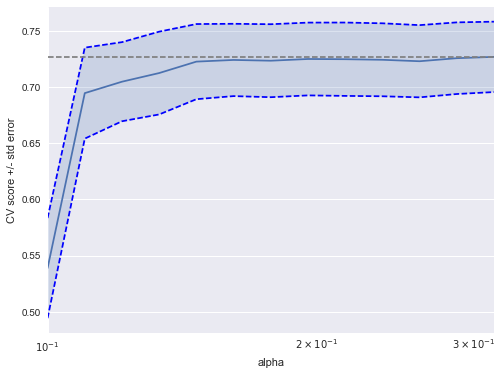

In [391]:
import matplotlib.pyplot as plt
scores, scores_std = np.array(scores), np.array(scores_std)
alphas = np.logspace(-1, -0.5, 13)

plt.figure().set_size_inches(8, 6)
plt.semilogx(alphas, scores)

std_error = scores_std / np.sqrt(n_folds)

plt.semilogx(alphas, scores + std_error, 'b--')
plt.semilogx(alphas, scores - std_error, 'b--')
plt.fill_between(alphas, scores + std_error, scores - std_error, alpha=0.2)

plt.ylabel('CV score +/- std error')
plt.xlabel('alpha')
plt.axhline(np.max(scores), linestyle='--', color='.5')
plt.xlim([alphas[0], alphas[-1]])

In [392]:
clf = RandomForestRegressor(n_estimators = 51, random_state=1)
clf.fit(X, Y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=51, n_jobs=1, oob_score=False, random_state=1,
           verbose=0, warm_start=False)

In [393]:
# top 20 features:
features = X.columns.values
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]

num_to_plot = 20
feature_indices = [ind+1 for ind in indices[:num_to_plot]]

for i in range(num_to_plot):
    print features[feature_indices[i]], round(importances[indices[i]],4)

novostavba_le 0.7045
velikost=1+1 0.0501
location=Hlavní, Praha 4 - Záběhlice 0.0113
stavOb=beforeRec 0.011
location=Limuzská, Praha 10 - Malešice 0.0094
location=Jeronýmova, Praha 3 - Žižkov 0.0087
location=Národní obrany, Praha 6 - Bubeneč 0.0079
location=K Červenému dvoru, Praha 3 - Strašnice 0.0071
velikost=4+1 0.006
location=Irská, Praha 6 - Vokovice 0.0059
floor=15 0.0058
location=Spinozova, Praha - Modřany 0.0052
location=Biskupcova, Praha 3 - Žižkov 0.0051
location=Libická, Praha - Vinohrady 0.0045
floor=6 0.0043
location=Na Pankráci, Praha 4 - Nusle 0.004
floor=-1 0.0037
parkovani_le 0.0037
location=Jabloňová, Praha 10 - Záběhlice 0.0034
location=Praha 3 - Strašnice 0.0034


In [394]:
predictions = pd.Series(clf.predict(X), index=Y.index)
res_info_forest = pd.DataFrame(columns=['Error,%',u'Error,Kč',u'Price,Kč',u'Price,m²', u'URL'])
for i in Y.index:
    error = Y[i] - predictions[i]
    rel_error = error/predictions[i]*100
    #if np.abs(rel_error)>15:
    res_info_forest.loc[i] = pd.Series({
            'Error,%':round(rel_error,1),
            u'Error,Kč':'{:,}'.format(int(error)),
            u'Price,Kč':'{:,}'.format(Y[i]),
            u'Price,m²':'{:,}'.format(int(Y[i]/X['plocha'][i])),
            'URL':'{}/{}/'.format(' https://www.sreality.cz/detail/prodej/byt', df['url'][i])
    })
    

In [395]:
import xgboost as xgb
scores = list()
scores_std = list()
kf = KFold(n_splits=n_folds, shuffle=True, random_state=1)
def determine_forest_quality(trees_count):
    clf = xgb.XGBRegressor(n_estimators = trees_count, max_depth = n_folds)
    score = cross_val_score(clf, X, Y, scoring='r2', cv=kf)
    scores.append(np.mean(score))
    scores_std.append(np.std(score))
    return score.mean()

for k in range(1,62,5):
    quality = determine_forest_quality(k)    
    print (k, quality)


(1, -2.8113029878894493)
(6, -0.5120226400890785)
(11, 0.28165097441687043)
(16, 0.56175072282769234)
(21, 0.65836205550809868)
(26, 0.69260359711276998)
(31, 0.70814731545767817)
(36, 0.71550931068434642)
(41, 0.72032320709039721)
(46, 0.7241446139334442)
(51, 0.72516955970398189)
(56, 0.72644152850814725)
(61, 0.72768586584007555)


(1.0000000000000001e-05, 0.31622776601683794)

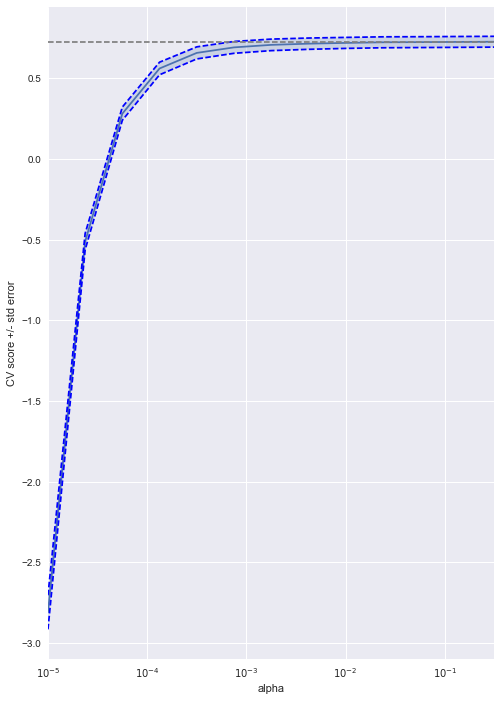

In [396]:
scores, scores_std = np.array(scores), np.array(scores_std)
alphas = np.logspace(-5, -0.5, 13)

plt.figure().set_size_inches(8, 12)
plt.semilogx(alphas, scores)

std_error = scores_std / np.sqrt(n_folds)

plt.semilogx(alphas, scores + std_error, 'b--')
plt.semilogx(alphas, scores - std_error, 'b--')
plt.fill_between(alphas, scores + std_error, scores - std_error, alpha=0.2)

plt.ylabel('CV score +/- std error')
plt.xlabel('alpha')
plt.axhline(np.max(scores), linestyle='--', color='.5')
plt.xlim([alphas[0], alphas[-1]])

In [397]:
clf = xgb.XGBRegressor(n_estimators = 51, max_depth = n_folds)
clf.fit(X, Y)
features = X.columns.values
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]

num_to_plot = 20
feature_indices = [ind+1 for ind in indices[:num_to_plot]]

for i in range(num_to_plot):
    print features[feature_indices[i]], round(importances[indices[i]],4)

novostavba_le 0.2342
velikost=1+1 0.0324
location=K Červenému dvoru, Praha 3 - Strašnice 0.0243
location=Jeronýmova, Praha 3 - Žižkov 0.0206
stavOb=beforeRec 0.0177
velikost=3+1 0.0169
location=Hlavní, Praha 4 - Záběhlice 0.0162
floor=15 0.0162
sklep_le 0.0155
location=Limuzská, Praha 10 - Malešice 0.0155
location=Libická, Praha - Vinohrady 0.0147
vlastnictvi=osobni 0.014
floor=3 0.0133
location=Jabloňová, Praha 10 - Záběhlice 0.0133
location=Biskupcova, Praha 3 - Žižkov 0.0118
balkon= 0.0118
location=Štefánikova, Praha - Smíchov 0.011
stavOb=veryGood 0.011
floor=7 0.011
stavba=ostatni 0.0103


In [398]:
predictions = pd.Series(clf.predict(X), index=Y.index)
res_info = pd.DataFrame(columns=['Error,%','Error forest,%',u'Error,Kč',u'Error forest,Kč',u'Price,Kč',u'Price,m²', u'URL'])
for i in Y.index:
    error = Y[i] - predictions[i]
    rel_error = error/predictions[i]*100
    #if np.abs(rel_error)>15:
    res_info.loc[i] = pd.Series({
            u'Error,%':round(rel_error,1),
            u'Error forest,%': res_info_forest['Error,%'][i],
            u'Error,Kč':'{:,}'.format(int(error)),
            u'Error forest,Kč': res_info_forest[u'Error,Kč'][i],
            u'Price,Kč':'{:,}'.format(Y[i]),
            u'Price,m²':'{:,}'.format(int(Y[i]/X['plocha'][i])),
            'URL':'{}/{}/'.format(' https://www.sreality.cz/detail/prodej/byt', df['url'][i])
    })
    
# Underpriced offers
pd.options.display.max_colwidth = 100
res_info.sort_values(by=u'Error,%')[:15]

,"Error,%","Error forest,%","Error,Kč","Error forest,Kč","Price,Kč","Price,m²",URL
2265391452,-25.6,-13.2,"-2,022,791","-896,666","5,890,000","51,666",https://www.sreality.cz/detail/prodej/byt/2+kk/praha-hlubocepy-hlubocepska/2265391452/
1018728796,-24.1,-16.9,"-942,333","-605,388","2,967,320","41,212",https://www.sreality.cz/detail/prodej/byt/2+1/praha-praha-14-/1018728796/
2887459164,-23.3,-8.5,"-946,100","-291,058","3,117,093","57,723",https://www.sreality.cz/detail/prodej/byt/2+kk/praha-letnany-miroslava-hajna/2887459164/
3249480028,-22.3,-15.9,"-922,300","-608,113","3,209,000","62,921",https://www.sreality.cz/detail/prodej/byt/2+kk/praha-letnany-veselska/3249480028/
2355044700,-22.0,-5.8,"-1,099,340","-240,022","3,890,000","61,746",https://www.sreality.cz/detail/prodej/byt/2+1/praha-vrsovice-kubanske-namesti/2355044700/
2227384668,-21.3,-19.0,"-1,055,360","-910,744","3,890,000","51,184",https://www.sreality.cz/detail/prodej/byt/4+kk/praha-zabehlice-svojsovicka/2227384668/
139927900,-20.8,-17.4,"-1,295,059","-1,040,765","4,939,000","46,594",https://www.sreality.cz/detail/prodej/byt/2+kk/praha-karlin-u-mlynskeho-kanalu/139927900/
204091740,-20.8,-7.8,"-1,050,131","-338,500","4,000,000","56,338",https://www.sreality.cz/detail/prodej/byt/2+kk/praha-stodulky-kodymova/204091740/
2191663452,-20.8,-7.8,"-983,557","-315,353","3,750,000","54,347",https://www.sreality.cz/detail/prodej/byt/2+kk/praha-liben-novakovych/2191663452/
1249259868,-20.4,-38.5,"-1,144,901","-2,801,435","4,470,000","40,636",https://www.sreality.cz/detail/prodej/byt/3+1/praha-vysocany-u-vysocanskeho-pivovaru/1249259868/


In [399]:
# Overpriced offers
res_info.sort_values(by='Error,%', ascending=False)[:15]

,"Error,%","Error forest,%","Error,Kč","Error forest,Kč","Price,Kč","Price,m²",URL
2783977820,37.4,24.4,"2,065,511","1,487,245","7,590,000","135,535",https://www.sreality.cz/detail/prodej/byt/2+kk/praha-vinohrady-korunni/2783977820/
1315119452,36.3,17.6,"1,970,683","1,105,294","7,400,000","148,000",https://www.sreality.cz/detail/prodej/byt/2+kk/praha-stare-mesto-u-obecniho-dvora/1315119452/
3694797148,32.5,9.2,"1,273,692","438,431","5,190,000","101,764",https://www.sreality.cz/detail/prodej/byt/2+1/praha-smichov-na-zatlance/3694797148/
3976077660,31.8,24.1,"2,045,768","1,647,090","8,486,400","136,877",https://www.sreality.cz/detail/prodej/byt/2+1/praha-nove-mesto-navratilova/3976077660/
4293665116,31.6,22.6,"2,064,131","1,584,639","8,600,000","128,358",https://www.sreality.cz/detail/prodej/byt/2+1/praha-praha-1-/4293665116/
3891732828,31.2,5.8,"1,639,687","377,835","6,900,000","116,949",https://www.sreality.cz/detail/prodej/byt/2+kk/praha-vinohrady-na-kozacce/3891732828/
266805596,31.2,11.8,"1,639,687","727,368","6,900,000","116,949",https://www.sreality.cz/detail/prodej/byt/2+kk/praha-vinohrady-na-kozacce/266805596/
2033983836,30.8,15.6,"2,071,480","1,186,886","8,798,000","111,367",https://www.sreality.cz/detail/prodej/byt/3+kk/praha-dejvice-sarecka/2033983836/
1713840476,30.2,9.7,"1,973,543","750,588","8,500,000","104,938",https://www.sreality.cz/detail/prodej/byt/3+1/praha-dejvice-bubenecska/1713840476/
3438944604,30.0,12.0,"1,012,431","471,509","4,390,000","97,555",https://www.sreality.cz/detail/prodej/byt/2+kk/praha-vinohrady-libicka/3438944604/
